In [1]:
import matplotlib.pyplot as plt

from tools import *

def read_data(path, password):
    _df = crp.read_encrypted(path=path, password=password)
    _df = _df.fillna(0)
    _df /= 100  # change to decimal
    
    _df = _df.apply(lambda x : np.where(x > 1, 0, x))
    _df = _df.apply(lambda x : np.where(x < -1, 0, x))
    
    return _df

path = './public_data/'

file_name = 'release_5211.crypt'  # example: release_3547.crypt
password = 'LR2tgboMGxWtKhjM' 
df = read_data(path=path + file_name, password=password)

new_file_name = 'release_5211.crypt'
new_password = 'LR2tgboMGxWtKhjM'

In [2]:
ranks = pd.DataFrame()
data = df[-78:].copy()
ranks['Sortino'] = sortino_ratio(data).sort_values(ascending=False)
ranks['Max Drawdown'] = max_drawdown(data).sort_values(ascending=True)
ranks

,Sortino,Max Drawdown
strat_4,inf,-0.000000
strat_5,inf,-0.000000
strat_39,5.006669,0.077380
strat_29,4.636293,0.088331
strat_23,3.645000,0.037653
strat_11,3.613478,0.034843
strat_12,1.960560,0.059688
strat_3,1.763992,0.047184
strat_19,1.116064,0.093823
strat_24,0.907850,0.115480


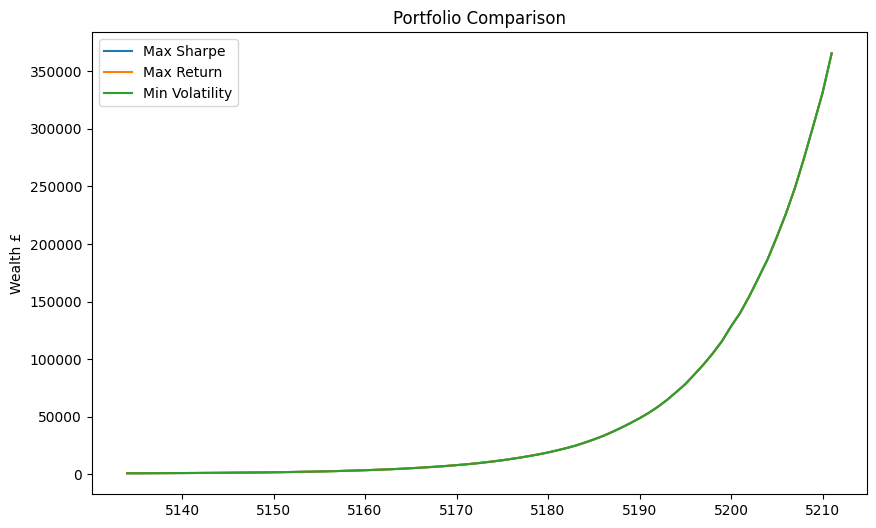

1.0000000000000002
1.0000000000000002


In [3]:
portfolio_weights = []
portfolio_returns = []
portfolio_risks = []
portfolio_sharpes = []

def compute_portfolio_return(_df, _weights):
    return (1 + np.sum(_weights * _df.mean())) ** 252 - 1

def compute_portfolio_risk(_df, _weights):  # portfolio variance formula
    return np.sqrt(_weights.T @ (_df.cov() * 252) @ _weights)

def compute_random_portfolio(_df, _iterations) -> None:
    ranks = sortino_ratio(_df).sort_values(ascending=False).index[:24] 
    ranks = [int(strat[6:]) for strat in ranks]
    no_of_stocks = _df.shape[1]
    
    rank_4 = ranks[:4] # top 4
    for i in range(_iterations):
        weights = np.zeros(no_of_stocks)
        for n in range(no_of_stocks):
            if n in rank_4 or n not in ranks:
                weights[n] = 0
            else:
                x = np.random.random()
                if x > 0.1:
                    x /= 2
                weights[n] = x + 0.001
                
        weights = weights.round(4)
        weights /= abs(weights).sum()
        weights *= 0.6
        
        for n in rank_4:
            weights[n] = 0.1
        
        portfolio_weights.append(weights)
        
        expected_return = compute_portfolio_return(_df, weights)
        portfolio_returns.append(expected_return)
        
        risk = compute_portfolio_risk(_df, weights)
        portfolio_risks.append(risk)
        
        sharpe = expected_return / risk
        portfolio_sharpes.append(sharpe)
    
data = df[-78:]

# run the simulations
compute_random_portfolio(data, 10_000)

# get the Max Sharpe Ratio, Max Return, Min Volatility
max_sharpe = max(portfolio_sharpes)
max_return = max(portfolio_returns)
min_risk = min(portfolio_risks)

# find the portfolio index for each
sharpe_idx = portfolio_sharpes.index(max_sharpe)
return_idx = portfolio_returns.index(max_return)
min_risk_idx = portfolio_risks.index(min_risk)

# find the portfolio weights for each
sharpe_w = portfolio_weights[sharpe_idx]
max_return_w = portfolio_weights[return_idx]
min_risk_w = portfolio_weights[min_risk_idx]

INITIAL_CASH = 1_000

def compute_wealth(_df, _weights):
    initial_values = (1 + _df.iloc[0]) * _weights * INITIAL_CASH
    cumulative_ret = np.cumprod(1 + _df)
    cumulative_wealths = cumulative_ret * initial_values
    
    return cumulative_wealths.sum(axis=1)


values = pd.DataFrame()
values['Max Sharpe'] = compute_wealth(data, sharpe_w)
values['Max Return'] = compute_wealth(data, max_return_w)
values['Min Volatility'] = compute_wealth(data, min_risk_w)

plt.figure(figsize=(10, 6))
plt.plot(values['Max Sharpe'], label='Max Sharpe')
plt.plot(values['Max Return'], label='Max Return')
plt.plot(values['Min Volatility'], label='Min Volatility')
plt.title('Portfolio Comparison')
plt.ylabel('Wealth £')
plt.legend()
plt.show()

# find the portfolio weights
results_weights = pd.DataFrame(index=data.columns)
results_weights['max sharpe ratio'] = sharpe_w
results_weights['max return'] = max_return_w
results_weights['min risk'] = min_risk_w 

clipped_weights = results_weights['max sharpe ratio']
print(sum(clipped_weights))

# clipped_weights
# more = sum(clipped_weights) - 1
# if more != 0:
#     stuff = results_weights['max sharpe ratio'].sort_values(ascending=False)
#     print(stuff)
#     idx = 0
#     if more > 0:
#         while more > 0:
#             if stuff[idx] < 0.1:
#                 more += stuff[idx] - 0.1
#                 stuff[idx] = 0.1
#             elif stuff[idx] > 0.1:
#                 if 0.1 - stuff[idx] > more: # can fill in whole gap with more
#                     stuff[idx] += more
#                     more = 0
#                 else:
#                     more -= (0.1 - stuff[idx])
#                     stuff[idx] = 0.1
#     else: # we are missing stuff
#         more *= -1
#         while more > 0:
#             if stuff[idx] < 0.1:
#                 more += stuff[idx] - 0.1
#                 stuff[idx] = 0.1
#             elif stuff[idx] > 0.1:
#                 if 0.1 - stuff[idx] > more: # can fill in whole gap with more
#                     stuff[idx] += more
#                     more = 0
#                 else:
#                     more -= (0.1 - stuff[idx])
#                     stuff[idx] = 0.1
# clipped_weights = results_weights['max sharpe ratio']
print(sum(clipped_weights))

In [4]:
pos_dict = clipped_weights.to_dict()
get_submission_dict(pos_dict)

{'strat_0': 0.0,
 'strat_1': 0.06349140032031196,
 'strat_2': 0.0,
 'strat_3': 0.00820277139474967,
 'strat_4': 0.09999999999999998,
 'strat_5': 0.09999999999999998,
 'strat_6': 0.0,
 'strat_7': 0.03515075551841794,
 'strat_8': 0.0,
 'strat_9': 0.0,
 'strat_10': 0.0,
 'strat_11': 0.02036069911566047,
 'strat_12': 0.023577745282361954,
 'strat_13': 0.0,
 'strat_14': 0.0,
 'strat_15': 0.0,
 'strat_16': 0.0,
 'strat_17': 0.0,
 'strat_18': 0.002214330478378943,
 'strat_19': 0.050107931202562496,
 'strat_20': 0.032574333263700295,
 'strat_21': 0.0,
 'strat_22': 0.0,
 'strat_23': 0.02169765336675719,
 'strat_24': 0.009609358679757677,
 'strat_25': 0.0,
 'strat_26': 0.0,
 'strat_27': 0.029858644941160084,
 'strat_28': 0.0,
 'strat_29': 0.09999999999999998,
 'strat_30': 0.0,
 'strat_31': 0.0,
 'strat_32': 0.008021725506580321,
 'strat_33': 0.0622937121370378,
 'strat_34': 0.0,
 'strat_35': 0.035471067474409854,
 'strat_36': 0.0,
 'strat_37': 0.04886846319894157,
 'strat_38': 0.0115590836292737

In [5]:
df1 = read_data(path + new_file_name, new_password)
pnls = pnl(df1[-78:], clipped_weights)

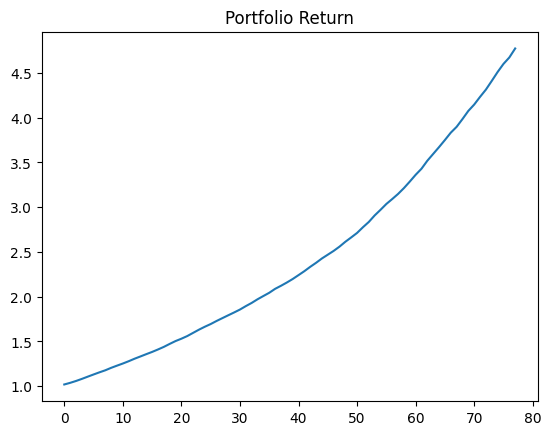

In [6]:
plt.plot(np.cumprod(1 + pnls))
plt.title('Portfolio Return')
plt.show()

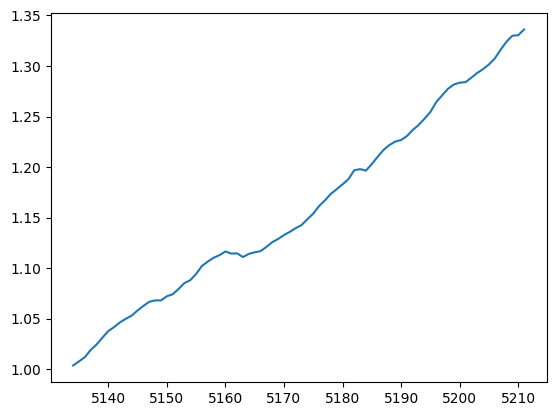

In [7]:
plt.plot(np.cumprod(1 + df1[-78:].mean(axis=1)))
